In [22]:
import mysql.connector
import pandas as pd

import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:

# Establish the connection
connection = mysql.connector.connect(
    host='localhost',
    database='vedanth',
    user='root',
    password=''  # No password is specified here
)

# Query to fetch data
query = "SELECT * FROM customers;"
df_customers = pd.read_sql(query, connection)

query = "SELECT * FROM accounts;"
df_accounts = pd.read_sql(query, connection)

query = "SELECT * FROM transactions;"
df_transactions = pd.read_sql(query, connection)

# Close the connection
connection.close()




C:\Users\Aravind\AppData\Local\Temp\ipykernel_13156\3773654610.py:11: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\Aravind\AppData\Local\Temp\ipykernel_13156\3773654610.py:14: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\Aravind\AppData\Local\Temp\ipykernel_13156\3773654610.py:17: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [13]:
# Display the first few rows of the DataFrame
print(df_customers.head())

   CustomerID FirstName LastName                    Email
0           1      John      Doe       john.doe@email.com
1           2      Jane      Doe       jane.doe@email.com
2           3   Michael    Smith  michael.smith@email.com
3           4     Emily    Jones    emily.jones@email.com
4           5   William    Brown  william.brown@email.com


In [14]:
# Display the first few rows of the DataFrame
print(df_accounts.head())

   AccountID  CustomerID AccountType  Balance
0          1           1    Checking   1500.0
1          2           1     Savings   4500.5
2          3           2     Savings   5500.0
3          4           3    Checking   2000.0
4          5           4     Savings   1500.0


In [15]:
# Display the first few rows of the DataFrame
print(df_transactions.head())

   TransactionID  AccountID TransactionType  Amount TransactionDate
0              1          1         Deposit   500.0      2023-08-10
1              2          2      Withdrawal   200.0      2023-09-12
2              3          2         Deposit  1000.0      2023-12-15
3              4          3      Withdrawal   550.0      2023-12-20
4              5          4         Deposit   645.0      2023-11-05


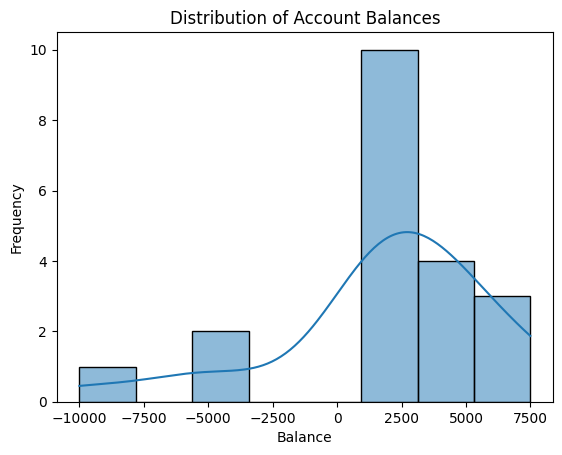

In [16]:


# Assuming df_accounts contains Account information
# Visualization of Account Balances distribution
sns.histplot(data=df_accounts, x="Balance", kde=True)
plt.title('Distribution of Account Balances')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()


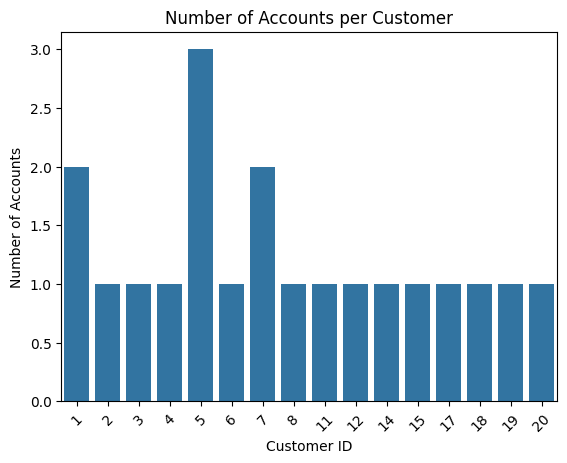

In [17]:
# Assuming a merge has been done correctly
accounts_per_customer = df_accounts['CustomerID'].value_counts()

sns.barplot(x=accounts_per_customer.index, y=accounts_per_customer.values)
plt.title('Number of Accounts per Customer')
plt.xlabel('Customer ID')
plt.ylabel('Number of Accounts')
plt.xticks(rotation=45)
plt.show()


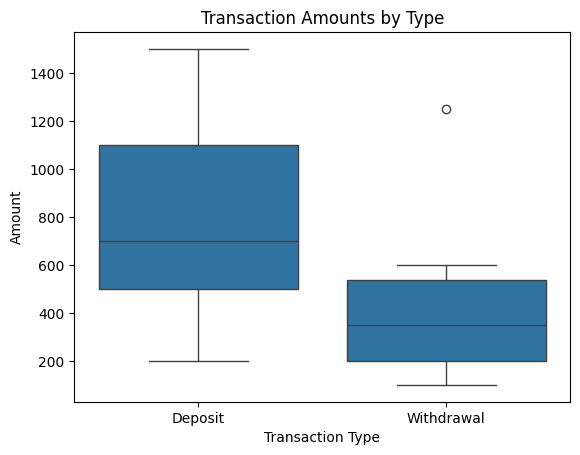

In [18]:
# Assuming df_transactions contains transaction information
sns.boxplot(data=df_transactions, x='TransactionType', y='Amount')
plt.title('Transaction Amounts by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Amount')
plt.show()


In [19]:

# Assuming df_accounts and df_customers are already defined and populated

# Create a simple aggregation: Count accounts by CustomerID
account_counts = df_accounts['CustomerID'].value_counts().reset_index()
account_counts.columns = ['CustomerID', 'AccountCount']

# Merge with customers to get names (optional, for nicer labels)
account_counts = account_counts.merge(df_customers[['CustomerID', 'FirstName', 'LastName']], on='CustomerID')
account_counts['CustomerName'] = account_counts['FirstName'] + ' ' + account_counts['LastName']



In [20]:
# Create a Dash application
app = dash.Dash(__name__)

# Define the layout
app.layout = html.Div(children=[
    html.H1(children='Bank Dashboard'),

    dcc.Graph(
        id='accounts-per-customer',
        figure=px.bar(account_counts, x='CustomerName', y='AccountCount', title='Accounts per Customer')
    )
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [21]:
# Assuming df_customers, df_accounts, and df_transactions are already defined
# Merging Customers and Accounts
df_customer_accounts = pd.merge(df_customers, df_accounts, on='CustomerID')
# Merging the above with Transactions
df_full_data = pd.merge(df_customer_accounts, df_transactions, on='AccountID')


In [23]:
# Initialize the Dash app
app = dash.Dash(__name__)

# App layout
app.layout = html.Div(children=[
    html.H1("Banking Dashboard"),
    
    dcc.Dropdown(
        id='customer-dropdown',
        options=[{'label': i, 'value': i} for i in df_customers['CustomerID'].unique()],
        value=df_customers['CustomerID'].unique()[0],
        clearable=False
    ),
    
    dcc.Graph(id='account-balance-graph'),
    
    html.Div(id='transaction-summary')
])

# Callback for updating the account balance graph based on selected customer
@app.callback(
    Output('account-balance-graph', 'figure'),
    Input('customer-dropdown', 'value')
)
def update_graph(selected_customer):
    filtered_df = df_full_data[df_full_data['CustomerID'] == selected_customer]
    fig = px.bar(filtered_df, x='AccountID', y='Balance', color='AccountType', title="Account Balances")
    return fig

# Callback for updating transaction summary
@app.callback(
    Output('transaction-summary', 'children'),
    Input('customer-dropdown', 'value')
)
def update_summary(selected_customer):
    filtered_df = df_full_data[df_full_data['CustomerID'] == selected_customer]
    total_deposits = filtered_df[filtered_df['TransactionType'] == 'Deposit']['Amount'].sum()
    total_withdrawals = filtered_df[filtered_df['TransactionType'] == 'Withdrawal']['Amount'].sum()
    return html.Div([
        html.H4("Transaction Summary"),
        html.P(f"Total Deposits: {total_deposits}"),
        html.P(f"Total Withdrawals: {total_withdrawals}")
    ])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)